In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def criaDatasetBidimensionalBinárioNãoLinearmenteSeparável(n=20):
    """
    Cria um dataset bidimensional Binário não linearmente separável.
    """
    X, y = make_blobs(n_samples=n, centers=[[0,0],[1,0],[1,1],[0,1]], cluster_std=0.1)
    y = np.array(y%2, dtype=int)
    return X, y

X, y = criaDatasetBidimensionalBinárioNãoLinearmenteSeparável(1000)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

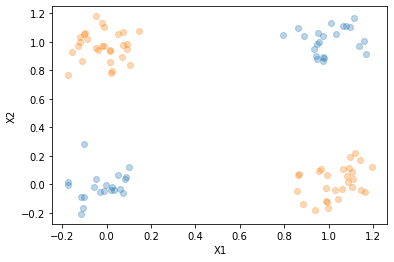

In [2]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

In [3]:
def define_axes(X):
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-.1, max1+.1, min2-.1, max2+.1]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [4]:
def sign(a):
    return (a >= 0) * 2 - 1

In [5]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [6]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y, activation):
        pass


class PseudoInversa(TrainingAlgorithm):
    def __init__(self, regularization=0):
        self.regularization = regularization
    def getW(self, X, y):
        if self.regularization == 0:
            return np.linalg.pinv(X) @ y
        return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y


In [7]:
from scipy.special import expit

def tanh(a):
    return expit(a)*2-1

1.0
1.0


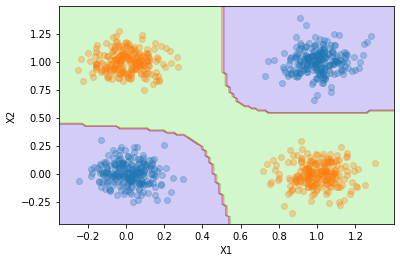

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

class ELM(BaseEstimator, ClassifierMixin):
    """
    Versão do ELM multiclasse.
    """
    def __init__(self, n_hidden=10, regularization=0):
        self.ihw = None
        self.how = None
        self.activation = tanh
        self.n_hidden = n_hidden
        self.training_algorithm = PseudoInversa(regularization)
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    def encode_labels(self, y):
        self.labels = list(set(y))
        return label_binarize(y, classes=self.labels)*2-1

    def fit(self, X, y):
        Xb = ELM.includebias(X)
        self.ihw = np.random.uniform(-1, 1, size=(Xb.shape[1],self.n_hidden))
        H = self.__input2hidden_activation(Xb)
        Hb = ELM.includebias(H)
        yhot = self.encode_labels(y)
        self.how = self.training_algorithm.getW(Hb, yhot)
    
    def __input2hidden_activation(self, X):
        return self.activation(np.matmul(X, self.ihw))

    def predict(self, X):
        Xb = ELM.includebias(X)
        H = self.__input2hidden_activation(Xb)
        Hb = ELM.includebias(H)
        a = np.matmul(Hb, self.how)
        if self.how.shape[1] == 1:
            idx = np.array(a > 0, dtype=int).reshape((-1,))
        else:
            idx = np.argmax(a, axis=1) 
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

elm = ELM(50, 0.1)
elm.fit(Xtr, ytr)
print(accuracy(ytr, elm.predict(Xtr)))
print(accuracy(yte, elm.predict(Xte)))
plotaDatasetBidimensional(Xte, yte)
plot_predictions(elm, Xte)

